# Identify a Case for the AMS Open Radar Short Course 2023

## Imports

In [5]:
import glob
import fsspec
# import s3f3
import pyart
import matplotlib.pyplot as plt
import pydda
# import warnings
# warnings.filterwarnings("ignore")

In [6]:
!pip3 install fsspec

Defaulting to user installation because normal site-packages is not writeable


## April 2008

### UAH ARMOR Radar

In [7]:
files = glob.glob('../../data/uah-armor/*')
radar = pyart.io.read(files[1])

/usr/local/anaconda3/lib/python3.8/site-packages/pyart/io/sigmet.py:131: RuntimeWarning: invalid value encountered in sqrt
  sigmet_data, sigmet_metadata = sigmetfile.read_data(full_xhdr=full_xhdr)


In [8]:
nyquist = radar.instrument_parameters['nyquist_velocity']['data'][0]
vel_dealias = pyart.correct.dealias_region_based(radar,
                                                    vel_field='velocity',
                                                    nyquist_vel=nyquist,
                                                    centered=True,
                                                    )
radar.add_field('corrected_velocity', vel_dealias, replace_existing=True)

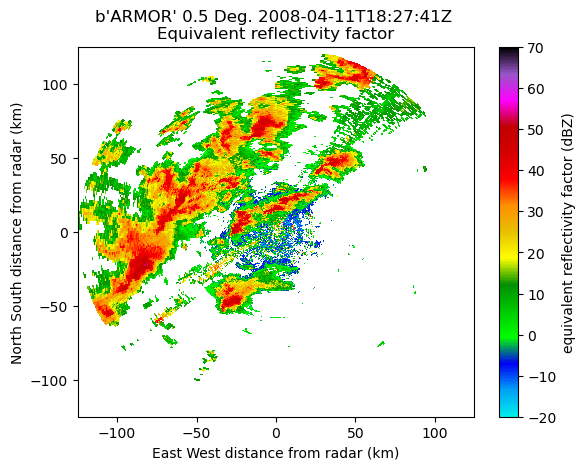

In [9]:
display = pyart.graph.RadarDisplay(radar)
display.plot('reflectivity',
             vmin=-20,
             vmax=70,
             cmap='pyart_NWSRef',
             sweep=0)

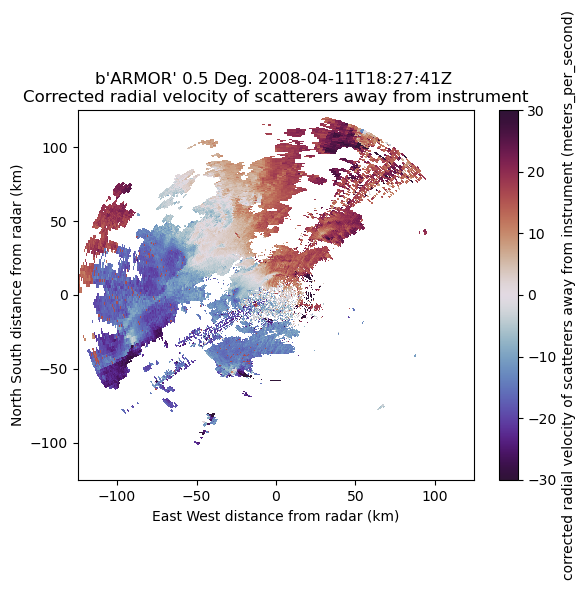

In [10]:
display = pyart.graph.RadarDisplay(radar)
display.plot('corrected_velocity',
             vmin=-30,
             vmax=30,
             cmap='twilight_shifted',
             sweep=0)

In [11]:
grid_limits = ((0., 15000.), (-50_000., 50_000.), (-50_000., 50_000.))
grid_shape = (31, 201, 201)
uah_grid = pyart.map.grid_from_radars([radar], grid_limits=grid_limits,
                                 grid_shape=grid_shape)
uah_ds = uah_grid.to_xarray()
uah_ds

/usr/local/anaconda3/lib/python3.8/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


<xarray.Dataset>
Dimensions:                      (time: 1, z: 31, y: 201, x: 201)
Coordinates:
  * time                         (time) object 2008-04-11 18:27:41
  * z                            (z) float64 0.0 500.0 ... 1.45e+04 1.5e+04
    lat                          (y) float64 34.2 34.2 34.2 ... 35.09 35.09
    lon                          (x) float64 -87.32 -87.31 ... -86.23 -86.23
  * y                            (y) float64 -5e+04 -4.95e+04 ... 4.95e+04 5e+04
  * x                            (x) float64 -5e+04 -4.95e+04 ... 4.95e+04 5e+04
Data variables:
    specific_differential_phase  (time, z, y, x) float32 nan nan nan ... nan nan
    differential_reflectivity    (time, z, y, x) float32 nan nan nan ... nan nan
    spectrum_width               (time, z, y, x) float32 nan nan nan ... nan nan
    differential_phase           (time, z, y, x) float32 nan nan nan ... nan nan
    corrected_velocity           (time, z, y, x) float32 nan nan nan ... nan nan
    cross_correlation_ratio      (time, z, y, x) float32 nan nan nan ... nan nan
    total_power                  (time, z, y, x) float32 nan nan nan ... nan nan
    reflectivity                 (time, z, y, x) float32 nan nan nan ... nan nan
    velocity                     (time, z, y, x) float32 nan nan nan ... nan nan
    ROI                          (time, z, y, x) float32 1.852e+03 ... 2.602e+03

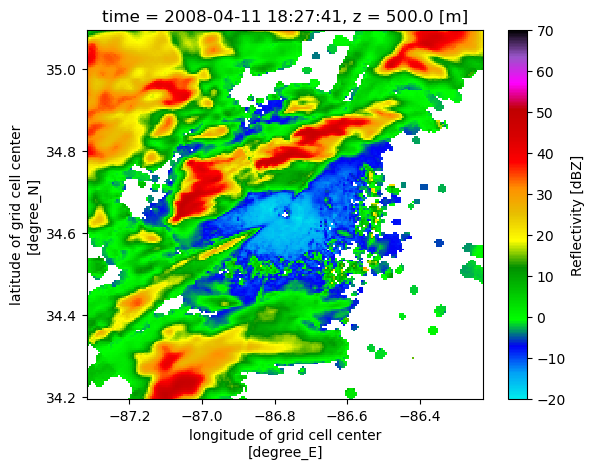

In [12]:
uah_ds.isel(z=1).reflectivity.plot(x='lon',
                                   y='lat',
                                   vmin=-20,
                                   vmax=70,
                                   cmap='pyart_NWSRef')

### NEXRAD Data

In [24]:
import fsspec, s3fs
fs = fsspec.filesystem("s3", anon=True)

ModuleNotFoundError: No module named 's3fs'

In [13]:
# files = sorted(fs.glob("s3://noaa-nexrad-level2/2008/04/11/KHTX/KHTX20080411_18*"))
# files
files = glob.glob('../../data/nextrad/*')
radar = pyart.io.read(files[1])

IndexError: list index out of range

Read a single file, the one closes to the UAH volume scan used before

In [ ]:
nexrad_radar = pyart.io.read_nexrad_archive(f's3://{files[4]}', station='KHTX')

In [ ]:
display = pyart.graph.RadarDisplay(nexrad_radar)
display.plot('reflectivity',
                     vmin=-20,
                     vmax=70,
                     cmap='pyart_ChaseSpectral',
                     sweep=0)
plt.ylim(-200, 200)
plt.xlim(-200, 200)

In [ ]:
# Use the ARMOR radar lat/lon as the center for the grid
grid_lat = radar.latitude['data'][0]
grid_lon = radar.longitude['data'][0]

# Make sure the velocity is called corrected velocity to match the corrected data from ARMOR
nexrad_radar.add_field_like('velocity',
                            'corrected_velocity',
                            nexrad_radar.fields['velocity']['data'],
                            replace_existing=True)

nexrad_grid = pyart.map.grid_from_radars([nexrad_radar],
                                         grid_limits=grid_limits,
                                         grid_shape=grid_shape,
                                         grid_origin = (grid_lat, grid_lon),
                                        )

# Convert to xarray and remove the time dimension
nexrad_ds = nexrad_grid.to_xarray().squeeze()

In [ ]:
nexrad_ds.reflectivity.isel(z=1).plot(x='lon',
                                      y='lat',
                                      cmap='Spectral_r',
                                      vmin=-20,
                                      vmax=70)

In [ ]:
nexrad_ds.velocity.isel(z=0).plot(x='lon',
                                  y='lat',
                                  cmap='twilight_shifted',
                                  vmin=-30,
                                  vmax=30)

In [ ]:
u_init, v_init, w_init = pydda.initialization.make_constant_wind_field(
    uah_grid, (0.0, 0.0, 0.0), vel_field='corrected_velocity')

In [ ]:
grids = pydda.retrieval.get_dd_wind_field([uah_grid, nexrad_grid], u_init,
                                          v_init, w_init, Co=1.0, Cm=256.0,
                                          Cx=1e-3, Cy=1e-3, Cz=1e-3, Cb=0.,
                                          frz=5000.0, filter_window=5,
                                          mask_outside_opt=True, upper_bc=1,
                                          vel_name='corrected_velocity',
                                          wind_tol=0.5, engine="tensorflow")

In [ ]:
ds = grids[1].to_xarray()

In [ ]:
ds.reflectivity.isel(z=0, time=0).plot()

In [ ]:
ds.w.isel(z=0, time=0,).plot( x='lon', y='lat')